# Feature Selection

The goal of this script is to identify a set of features in the data which can be used by all of the models for predicting erosion on the blades.

## Selection for Classification 

In [16]:
# First, just try a basic randomforest to see if it works.
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Load in the training and testing data
In_train = pd.read_table('../InTable_Train_1700.txt',delimiter=',')
In_test = pd.read_table('../InTable_Test_1700.txt',delimiter=',')

Out_train = pd.read_table('../OutTable_Train_1700.txt',delimiter=',')
Out_test = pd.read_table('../OutTable_Test_1700.txt',delimiter=',')

# Select the last row of the Out_train
Out_train_class = Out_train['TurbineAgeClass'].astype(str) 
Out_test_class = Out_test['TurbineAgeClass'].astype(str) 


print(Out_test_class.value_counts())

0.0     25
13.5    25
22.5    25
21.0    25
19.5    25
18.0    25
16.5    25
15.0    25
12.0    25
1.5     25
10.5    25
9.0     25
7.5     25
6.0     25
4.5     25
3.0     25
24.0    25
Name: TurbineAgeClass, dtype: int64


In [3]:
# Scale the data first
scaler = preprocessing.StandardScaler().fit(In_train)
In_train_scaled = scaler.transform(In_train)
In_test_scaled = scaler.transform(In_test)

# Select the model
RF = RandomForestClassifier(n_estimators = 30)

# Fit the model
RF.fit(In_train_scaled,Out_train_class)

# Predict with the model
Predict_class_train = RF.predict(In_train_scaled)
Predict_class_test = RF.predict(In_test_scaled)

# Score the prediction
from sklearn.metrics import roc_auc_score
score_train = roc_auc_score(Out_train_class, RF.predict_proba(In_train_scaled), multi_class='ovr')
score_test = roc_auc_score(Out_test_class, RF.predict_proba(In_test_scaled), multi_class='ovr')
print("Training Score")
print(score_train)
print("Testing Score")
print(score_test)

Training Score
1.0
Testing Score
0.9125352941176471


Now that we have a model trained, we must practice plotting the ROC curves.

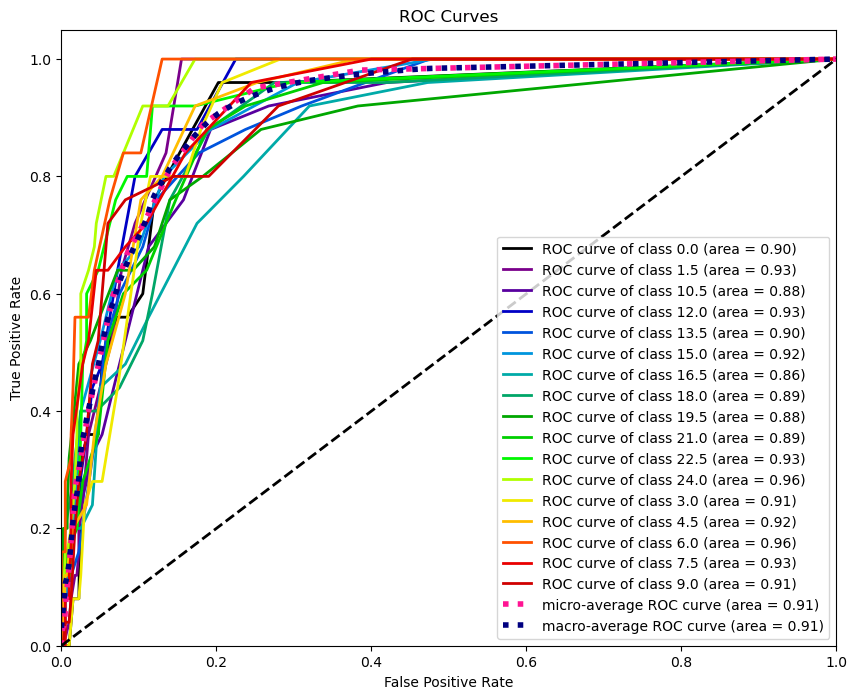

In [4]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = Out_test_class# ground truth labels
y_probas = RF.predict_proba(In_test_scaled)# predicted probabilities generated by sklearn classifier

skplt.metrics.plot_roc(y_true, y_probas,figsize=(10, 8))

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


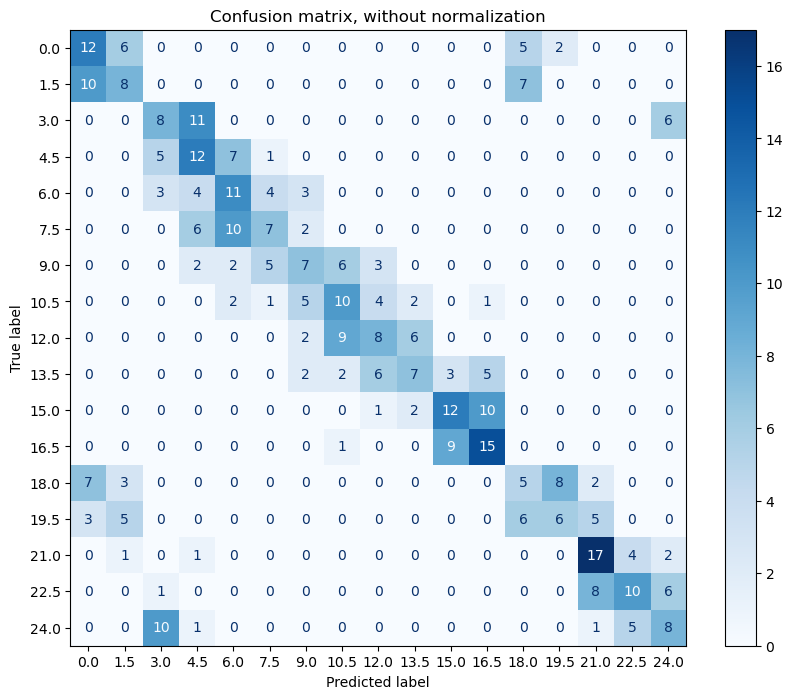

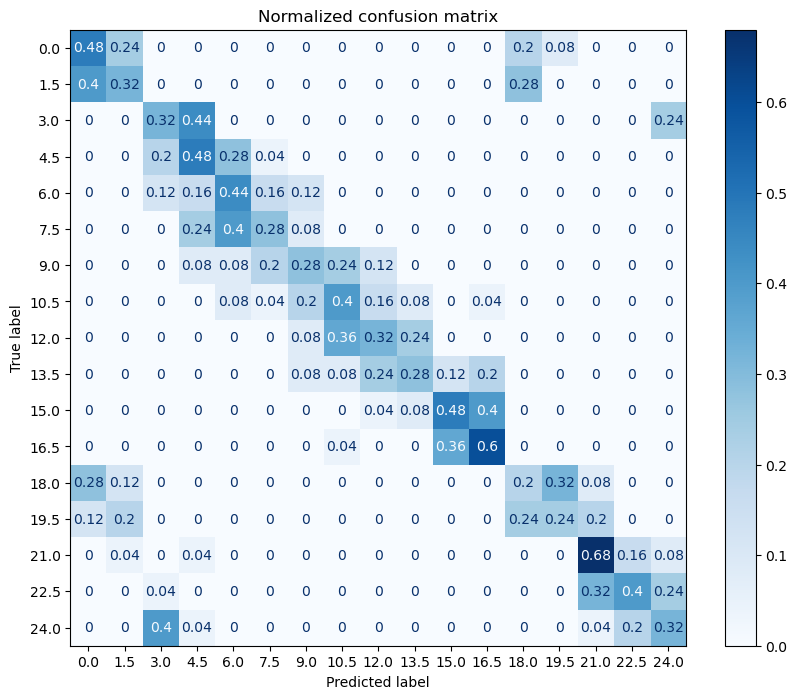

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)
class_names = Out_test_class.unique()
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    disp = ConfusionMatrixDisplay.from_estimator(
        RF,
        In_test_scaled,
        Out_test_class,
        display_labels=class_names,
        cmap=plt.cm.Blues,ax=ax1,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    

    print(title)
    #print(disp.confusion_matrix)

plt.show()

Next, we want to try a way to optimize the feature selection.  This method relies upon the Covariance Matrix Adaptation Evolution Strategy

In [17]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator
from cmaes import CMA, CMAwM
from tqdm.notebook import tqdm

class DummyEstimator(BaseEstimator):
    # mlxtend wants to use an sklearn estimator, which is not needed here
    # (statsmodels OLS is used instead)
    # create a dummy estimator to pacify mlxtend
    def fit(self, X, y=None, **kwargs):
        return self

X_cmaes_train = In_train.copy()
y_cmaes_train = Out_train_class.copy()

X_cmaes_test = In_test.copy()
y_cmaes_test = Out_test_class.copy()

# The objective function for the genetic algorithm (trains a forest each time)
def cma_objective(fs):
    features_use = [f for i, f in enumerate(features_select) if fs[i,] == 1]
    RF = RandomForestClassifier(n_estimators = 30)
    RF = RF.fit(X_cmaes_train[features_use],y_cmaes_train)
    auc = roc_auc_score(y_cmaes_test, RF.predict_proba(X_cmaes_test[features_use]), multi_class='ovr')
    return auc

features_select = [f for f in X_cmaes_train.columns]

dim = len(features_select)
bounds = np.tile([0, 1], (dim, 1))
steps = np.ones(dim)
optimizer = CMAwM(
    mean=np.full(dim, 0.5),
    sigma=1 / 6,
    bounds=bounds,
    steps=steps,
    n_max_resampling=10 * dim,
    seed=0,
)

max_gen = 100
best_objective_cmaes_small = np.inf
best_sol_raw_cmaes_small = None
for gen in tqdm(range(max_gen)):
    solutions = []
    for _ in range(optimizer.population_size):
        x_for_eval, x_for_tell = optimizer.ask()
        value = cma_objective(x_for_eval)
        solutions.append((x_for_tell, value))
        if value < best_objective_cmaes_small:
            best_objective_cmaes_small = value
            best_sol_raw_cmaes_small = x_for_eval
    optimizer.tell(solutions)

best_features_cmaes_small = [
    features_select[i]
    for i, val in enumerate(best_sol_raw_cmaes_small.tolist())
    if val == 1.0
]
print(f'best objective: {best_objective_cmaes_small}')
print(f'best features:  {best_features_cmaes_small}')


  0%|          | 0/100 [00:00<?, ?it/s]

best objective: 0.7375264705882353
best features:  ['Wind_Direction', 'Wind_Speed', 'BldPitch2', 'LSShftFya', 'LSShftFza', 'LSShftMxa', 'LSSTipMya', 'HSShftTq', 'HSShftPwr', 'RootFxb1', 'RootFzc2', 'RootMyb1', 'RootMyb2', 'RootMzc1', 'RootMzc3', 'TipDxc1', 'TipDxc3', 'TipDyc1', 'TipDzc2', 'TipDzc3', 'TipDxb2', 'TipDyb2', 'TipDyb3', 'TipALxb1', 'TipALyb3', 'TipALzb1', 'TipRDxb1', 'TipRDxb2', 'TipRDxb3', 'TipRDyb2', 'RotPwr', 'YawBrFxn', 'YawBrMxn', 'TwrBsFxt', 'TwrBsFyt', 'TwrBsMxt', 'TwrBsMzt', 'RtAeroFxh', 'RtAeroPwr', 'RtAeroMxh', 'RtAeroMzh', 'B1N1Alpha', 'B1N2Alpha', 'B2N3Alpha', 'B3N1Alpha', 'B3N2Alpha', 'B2N4Cl', 'B2N5Cl', 'B1N1Cd', 'B2N1Cd', 'B3N1Cd', 'GenTq', 'BldPitch3_std', 'LSShftFxa_std', 'LSShftFza_std', 'LSShftMxa_std', 'HSShftTq_std', 'HSShftPwr_std', 'LSSTipVxa_std', 'RootFxb1_std', 'RootFxb3_std', 'RootFyb1_std', 'RootFyb2_std', 'RootFyb3_std', 'RootFzc3_std', 'RootMxb1_std', 'RootMxb2_std', 'RootMyb3_std', 'RootMzc1_std', 'RootMzc2_std', 'TipDxc3_std', 'TipDyc1_std', 

This method didn't seem to do a whole lot for us.